# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by **concatenating character images** from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to **five digits, and use five classifiers on top of your deep network**. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

=============================================================================================================
# My strategy:
1. Download SVHN dataset and observe its data structure. Have an rough idea what should be considered in my deep learning model.
2. Import mnist dataset and build a neural network.
3. Generate blank character and mix with real character, build a binary classifier to predict whether it is a digit.
4. Combine binary classifier and network classifier to recognize the possible single digit. 
5. Generate 2-digit synthetic dataset from MNIST, optimize model to make it work.
6. Generate 5-digit synthetic datase and modify model.

## step 1, observe SVHN
### format 1
After unzipping the .tar.gz file, the train folder have 33402 .png files, 1 digitStruct.mat file. Using Matlab open this .mat file, I get a 1* 33402 struct. Each struct has 2 fields: name, bbox. name is png file name; bbox is the location of blue box, which is represent by a struct with 5 fields: height, left, top, width, label. After some experiment, I figure out how to show the digits in the blue box:
```python
import cv2
path = 'train/1.png'
image = cv2.imread(path)
cropped = image[top:top+height, left:left+width]
cv2.imshow("cropped", cropped)
cv2.waitKey(0)
```

So the pixel size for the actual input is height*width. It will need resizing for practical use. Another thing is convert color to grey scale.

### format 2
The train32x32.mat has 2 variables, X has a shape of 32\*32\*3\*73257, y is just 73257 digit labels. Note that y has 10 but not 0. So actually format 2 is single digit recognition, which can serve as inital experiments if needed.

## step 2, build binary classifier, check mnist data
1. import mnist data organized by michael nielsen, check data and random data
2. use Tensorflow build a simple network with relu and L2,  

In [31]:
from six.moves import cPickle 
import gzip
with gzip.open('mnist.pkl.gz', 'rb') as f:
    training_data, validation_data, test_data = cPickle.load(f)
[X_train, y_train] = training_data
[X_valid, y_valid] = validation_data
[X_test, y_test] = test_data

In [32]:
# convert labels to 1-hot encoding
import numpy as np

def oneHot(lables):
  return (np.arange(10) == lables[:,None]).astype(np.float32)

y_train = oneHot(y_train)
y_valid = oneHot(y_valid)
y_test = oneHot(y_test)
print X_train.shape
print y_train.shape

(50000, 784)
(50000, 10)


1


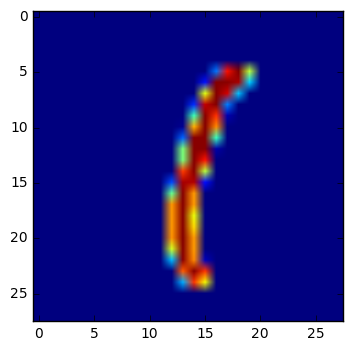

In [47]:
import matplotlib.pyplot as plt
% matplotlib inline
index = np.random.randint(y_train.shape[0])
sample_image = X_train[index].reshape((28,28))  # extract a 2D slice
print np.argmax(y_train[index])
plt.figure()
plt.imshow(sample_image)  # display it

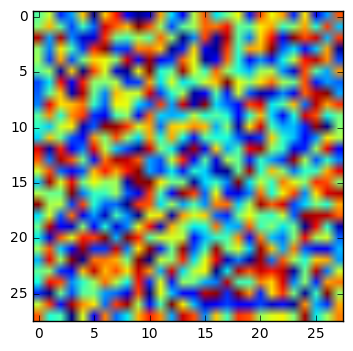

In [48]:
r = np.random.rand(28,28)
plt.figure()
plt.imshow(r)  # display it

In [33]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

### 784\*100\*10 network, relu hidden layer, softmax, cross entropy, L2 regulatio

In [216]:
import tensorflow as tf

from time import time

batch_size = 128  # original 128
hidden_size = 100 # original 1024
# estimated parameters: (784+1)*1024+(1024+1)*10 = 814 k
# reduced parameters: (784+1)*100+(100+1)*10 = 80 k

X = tf.placeholder(tf.float32,shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))

# input layer to hidden layer
weights1 = tf.Variable(tf.truncated_normal([784, hidden_size]))
biases1 = tf.Variable(tf.zeros([hidden_size]))
logits1 = tf.matmul(X, weights1) + biases1
hidden1 = tf.nn.relu(logits1)

# hidden layer to output layer
weights = tf.Variable(tf.truncated_normal([hidden_size, 10]))
biases = tf.Variable(tf.zeros([10]))
logits = tf.matmul(hidden1, weights) + biases

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,y)) +\
  0.01 * tf.nn.l2_loss(weights1) + 0.01 * tf.nn.l2_loss(weights)  # L2 regulation
optimizer = tf.train.GradientDescentOptimizer(0.3).minimize(loss)

# Predictions for the training, validation, and test data.
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
num_steps = 4001

# ------------------------------- execute phase -----------------  
t0= time()
feed_valid = {X: X_valid, y: y_valid}
feed_test  = {X: X_test, y: y_test}
  
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
print("Initialized")
for step in range(num_steps):
  offset = (step * batch_size) % (50000 - batch_size)
  batch_data = X_train[offset:(offset + batch_size), :]
  batch_labels = y_train[offset:(offset + batch_size), :]
  
  feed_train = {X: batch_data, y: batch_labels}
  sess.run(optimizer,feed_dict= feed_train)
  lo = sess.run(loss, feed_dict= feed_train)
  if (step % 500 == 0):

    print("Step = {0:4d}, loss = {1:5.2f},Valid accuracy ={2:g}".
          format(step,lo, sess.run(accuracy,feed_dict=feed_valid)))

print("Test accuracy: {0:g}".format(sess.run(accuracy,feed_dict=feed_test)))
print('Time cost:', time()-t0) # 94% at 10 seconds
sess.close()

Initialized
Step =    0, loss = 386.42,Valid accuracy =0.1642
Step =  500, loss = 15.29,Valid accuracy =0.9142
Step = 1000, loss =  1.24,Valid accuracy =0.9334
Step = 1500, loss =  0.65,Valid accuracy =0.9334
Step = 2000, loss =  0.43,Valid accuracy =0.9357
Step = 2500, loss =  0.50,Valid accuracy =0.9278
Step = 3000, loss =  0.45,Valid accuracy =0.9379
Step = 3500, loss =  0.50,Valid accuracy =0.9368
Step = 4000, loss =  0.45,Valid accuracy =0.9421
Test accuracy: 0.9407
('Time cost:', 14.347810983657837)


### convolutional nets

In [232]:
 # Weight Initialization
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# Convolution and Pooling
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10]) # labels

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32]) # 2D patch sizes, input/output channels
b_conv1 = bias_variable([32])

x_image = tf.reshape(X, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
# --------------------------------------------------------------------------------
# Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
# ---------------------------------------------------------------------------------
# Densely Connected Layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
# ---------------------------------------------------------------------------------
# Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)  # more sophisticated ADAM optimizer

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


feed_valid = {X: X_valid, y: y_valid, keep_prob: 1.0}
feed_test  = {X: X_test, y: y_test, keep_prob: 1.0}

# exectue phase ====================================================================
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print("Initialized")
t0 = time()
batch_size = 50
step_num = 2001
for step in range(step_num): # 
  offset = (step * batch_size) % (50000 - batch_size)
  batch_data = X_train[offset:(offset + batch_size), :]
  batch_labels = y_train[offset:(offset + batch_size), :]
  
  feed_train = {X: batch_data, y: batch_labels,keep_prob: 0.5}
  sess.run(train_step,feed_dict = feed_train)
  
  if step %200 == 0:
    valid_accuracy = sess.run(accuracy,feed_dict = feed_valid) # keep_prob in feed_dict to control the dropout rate.
    lo = sess.run(loss,feed_dict = feed_valid)
    print("step {0:d}, loss = {1:.5g}, validation accuracy {2:g}".format(step, lo, valid_accuracy))

print("test accuracy {0:g}".format(sess.run(accuracy,feed_dict = feed_test)))
print("time cost:",time()-t0) # 50 batch_size and 2001 steps get 97.6% in ?? seconds

Initialized
step 0, loss = 5.2458, validation accuracy 0.0647
step 100, loss = 0.50792, validation accuracy 0.8533
step 200, loss = 0.33507, validation accuracy 0.9019
step 300, loss = 0.26983, validation accuracy 0.9212
step 400, loss = 0.21267, validation accuracy 0.9393
step 500, loss = 0.18469, validation accuracy 0.9473
step 600, loss = 0.16973, validation accuracy 0.9529
step 700, loss = 0.15243, validation accuracy 0.9564
step 800, loss = 0.14864, validation accuracy 0.9572
step 900, loss = 0.14324, validation accuracy 0.9583
step 1000, loss = 0.12603, validation accuracy 0.9639
step 1100, loss = 0.11759, validation accuracy 0.9657
step 1200, loss = 0.11767, validation accuracy 0.9655
step 1300, loss = 0.10671, validation accuracy 0.9689
step 1400, loss = 0.096662, validation accuracy 0.9715
step 1500, loss = 0.095942, validation accuracy 0.9727
step 1600, loss = 0.088971, validation accuracy 0.9742
step 1700, loss = 0.092284, validation accuracy 0.9722
step 1800, loss = 0.09076

In [244]:
a = sess.run(y_conv,feed_dict= {X:X_train[0].reshape(1,784),keep_prob: 0.5})
print sess.run(tf.argmax(a,1))
print sess.run(tf.argmax(y_train[0].reshape(-1,1),0))

[5]
[5]


## step 3,  generate blank/valid dataset, build binary classifier
1. dataset size: 10k/10k
2. use sklearn classifier to check data

In [70]:
# generate blank/valid dataset
nb_rows = 20000
imag_size = 28*28
dataset = np.ndarray((nb_rows, imag_size), dtype=np.float32)
labels = np.ndarray(nb_rows, dtype=np.int32)
for i in range(10000):
  dataset[i] = np.random.rand(imag_size)
  labels[i] = 0
for i in range(10000,20000):
  index = np.random.randint(50000)
  dataset[i] = X_train[index]
  labels[i] = 1

In [77]:
# use sklearn model to train and get accuracy
from sklearn.model_selection import train_test_split
X1, X2,y1,y2 = train_test_split(dataset, labels, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(X1, y1)
print(clf.score(X2, y2))

1.0


## step 4, Combine binary classifier and network classifier to recognize the possible single digit. 

In [293]:
# test real data
def conv_predict(data):
  logit = sess.run(y_conv,feed_dict= {X:data.reshape(1,784),keep_prob: 1.0})
  return sess.run(tf.argmax(logit,1))
  
import warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")  # suppress warning caused by single sample test
  for i in range(10):
    index = np.random.randint(20000)
    exist = clf.predict(dataset[index])
    if exist[0] == 1:
      pred = conv_predict(dataset[index,:])
      print 'index = {0:5g}, predict = {1}'.format(index,pred[0])
    else:
      print 'index = {0:5g}, predict = {1}'.format(index,None)

index =  7667, predict = None
index =  8528, predict = None
index =  8291, predict = None
index =  3281, predict = None
index =  2286, predict = None
index = 11634, predict = 1
index = 19363, predict = 5
index =  9606, predict = None
index = 19169, predict = 7
index = 14565, predict = 7


## step 5, Generate 2-digit synthetic dataset from MNIST, optimize model to make it work.
1. dataset size: 1 k
2. check accuracy

In [307]:
num_rows = 1000
num_digits = 2
imag_size = 28*28
dataset_2d = np.ndarray((nb_rows,num_digits, imag_size), dtype=np.float32)
labels_2d = np.ones((nb_rows,num_digits),dtype = int)*10

for i in range(num_rows):
  for j in range(num_digits):
    dice = np.random.randint(11)
    if dice == 10:
      dataset_2d[i][j] = np.random.rand(imag_size)
    else:
      index = np.random.randint(50000)
      dataset_2d[i][j] = X_train[index]
      labels_2d[i][j]= np.argmax(y_train[index],0)

In [316]:
t0 = time()
import warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")  # suppress warning caused by single sample test
  
  result =[False for _ in range(num_rows)]
  for i in range(num_rows):
    predit = [10 for _ in range(num_digits)]
    for j in range(num_digits):
      data =dataset_2d[i,j]
      exist = clf.predict(data)
      if exist[0]:
        predit[j] = conv_predict(data)[0]
    if (predit == labels_2d[i]).all():
      result[i] = True
    if i % 100== 0:
      print i, np.mean(result)

print "time cost ={0}, accuracy = {1}".format(time()-t0,np.mean(result)) # get 95.3% in 660 seconds, reasonably good

0 0.001
100 0.095
200 0.189
300 0.282
400 0.376
500 0.47
600 0.569
700 0.664
800 0.758
900 0.855
time cost =661.468309879, accuracy = 0.953


## Step 6, Generate 5-digit synthetic datase and modify mode

In [317]:
num_rows = 100
num_digits = 5
imag_size = 28*28
dataset_5d = np.ndarray((nb_rows,num_digits, imag_size), dtype=np.float32)
labels_5d = np.ones((nb_rows,num_digits),dtype = int)*10

for i in range(num_rows):
  for j in range(num_digits):
    dice = np.random.randint(11)
    if dice == 10:
      dataset_5d[i][j] = np.random.rand(imag_size)
    else:
      index = np.random.randint(50000)
      dataset_5d[i][j] = X_train[index]
      labels_5d[i][j]= np.argmax(y_train[index],0)

In [318]:
t0 = time()
import warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")  # suppress warning caused by single sample test
  
  result =[False for _ in range(num_rows)]
  for i in range(num_rows):
    predit = [10 for _ in range(num_digits)]
    for j in range(num_digits):
      data =dataset_5d[i,j]
      exist = clf.predict(data)
      if exist[0]:
        predit[j] = conv_predict(data)[0]
    if (predit == labels_5d[i]).all():
      result[i] = True
    if i % 10== 0:
      print i, np.mean(result)

print "time cost ={0}, accuracy = {1}".format(time()-t0,np.mean(result)) # get 90% accuracy in 200 seconds

0 0.01
10 0.1
20 0.18
30 0.27
40 0.37
50 0.46
60 0.54
70 0.64
80 0.73
90 0.81
time cost =197.842850924, accuracy = 0.9


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:**  My strategy:
1. Download SVHN dataset and observe its data structure. Have an rough idea what should be considered in my deep learning model.
2. Import mnist dataset and build a neural network.
3. Generate blank character and mix with real character, build a binary classifier to predict whether it is a digit.
4. Combine binary classifier and network classifier to recognize the possible single digit. 
5. Generate 2-digit synthetic dataset from MNIST, optimize model to make it work.
6. Generate 5-digit synthetic datase and modify model.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** It's a combination of a sklearn classifier and a 5-layer(784,32,64,1024,10) neural network. The neural network has 2 convolutional layers and a dropoff layer

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** 
- Use individual digits to train the classifier.
- Use a 10:1 ratio to generate valid/blank digits, and put them in one training sample

shape =(28, 56)
lables=[7 6]


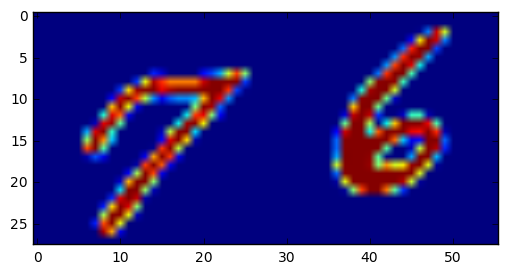

In [391]:
sample_idx = np.random.randint(num_rows)  # pick a random image index
a = dataset_2d[sample_idx,0].reshape(28,28)
b = dataset_2d[sample_idx,1].reshape(28,28)
sample_image = np.concatenate((a,b),axis=1) # extract a 2D slice
print 'shape ={0}'.format(sample_image.shape)
print 'lables={0}'.format(labels_2d[sample_idx])
plt.figure()
plt.imshow(sample_image)  # display it

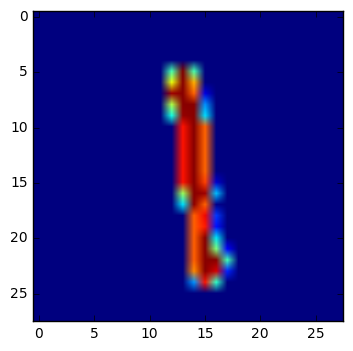

In [385]:
plt.figure()
plt.imshow(np.hsplit(sample_image,2)[0])  # display it

In [381]:
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])
c = np.concatenate((a,b),axis=1)
print c
print np.hsplit(c,2)

[[1 2 5 6]
 [3 4 7 8]]
[array([[1, 2],
       [3, 4]]), array([[5, 6],
       [7, 8]])]


shape =(28, 140)
lables=[ 0 10  9  6  4]


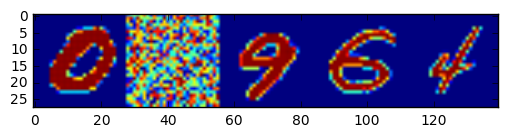

In [392]:
sample_idx = np.random.randint(num_rows)  # pick a random image index
a = dataset_5d[sample_idx,0].reshape(28,28)
b = dataset_5d[sample_idx,1].reshape(28,28)
c = dataset_5d[sample_idx,2].reshape(28,28)
d = dataset_5d[sample_idx,3].reshape(28,28)
e = dataset_5d[sample_idx,4].reshape(28,28)
sample_image = np.concatenate((a,b,c,d,e),axis=1) # extract a 2D slice
print 'shape ={0}'.format(sample_image.shape)
print 'lables={0}'.format(labels_5d[sample_idx])
plt.figure()
plt.imshow(sample_image)  # display it

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# Please see code implementation  in another file, SVHN.ipynb



### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**
- data setup:  I have tried both formats of data. I first used sklearn model as baseline to test the data, and found the accuracy is only 20%. For format 2, the data is already organized. I only convert 3D data to 2D data. For format 1, I need to read HDF data, imread, crop and resize 
- model performance: for single hidden layer net, format 1 get 65% accuracy, format 2 get 70% accuracy

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** options explored to improve results:
1. use bette quality data: format 1 vs format 2
2. single hidden layer neural network is far better than shallow machine learning like logistic regression and SVM
3. Convolutional neural network is even better. But the consuming time is at least 10 times longer. I first used 2 CNN layer + dropout layer, running 1 hours then computer no response, and I have to restart. 

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:** 
- initial result is 60% accuracy, final result is 73%
- It is not good enough. It should be at least 95% to beat human performance.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
# prepare data  -----------------------------------
import cPickle as pickle
with open('train_dataset_labels.pickle','rb') as f:
  (X_train,y_train) = pickle.load(f)
with open('train_dataset_labels.pickle','rb') as f:
  (X_test,y_test) = pickle.load(f)
  
nsamples, nx, ny = X_train.shape
X1 = X_train.reshape((nsamples,nx*ny))
train_num = nsamples  # 73 k

nsamples, nx, ny = X_test.shape
X2 = X_test.reshape((nsamples,nx*ny))  # 26k

import numpy as np
def oneHot(lables):
  return (np.arange(10) == lables[:,None]).astype(np.float32)

y1 = oneHot(y_train)
y2 = oneHot(y_test)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# neural netwok contruction phase ---------------------
import tensorflow as tf
from time import time

hidden_size = 100 # original 1024
# required parameters: (784+1)*100+(100+1)*10 = 80 k

X = tf.placeholder(tf.float32,shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))

# input layer to hidden layer
weights1 = tf.Variable(tf.truncated_normal([784, hidden_size]))
biases1 = tf.Variable(tf.zeros([hidden_size]))
logits1 = tf.matmul(X, weights1) + biases1
hidden1 = tf.nn.relu(logits1)

# hidden layer to output layer
weights = tf.Variable(tf.truncated_normal([hidden_size, 10]))
biases = tf.Variable(tf.zeros([10]))
logits = tf.matmul(hidden1, weights) + biases

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,y)) +\
  0.01 * tf.nn.l2_loss(weights1) + 0.01 * tf.nn.l2_loss(weights)  # L2 regulation
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

# Predictions for the training, validation, and test data.
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# ------------------------------- execute phase -----------------  
t0= time()
feed_valid = {X: X2, y: y2}
feed_test  = feed_valid
  
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
print("Initialized")

num_steps = 8001
batch_size = 128  
for step in range(num_steps):
  offset = (step * batch_size) % (train_num - batch_size)    
  batch_data = X1[offset:(offset + batch_size), :]
  batch_labels = y1[offset:(offset + batch_size), :]
  
  feed_train = {X: batch_data, y: batch_labels}
  sess.run(optimizer,feed_dict= feed_train)
  lo = sess.run(loss, feed_dict= feed_train)
  if (step % 1000 == 0):
    print("Step = {0:4d}, loss = {1:5.2f},Valid accuracy ={2:g}".
          format(step,lo, sess.run(accuracy,feed_dict=feed_valid)))

print("Test accuracy: {0:g}".format(sess.run(accuracy,feed_dict=feed_test)))
print('Time cost:', time()-t0)   # get 71% in 30 s

Initialized
Step =    0, loss = 346.43,Valid accuracy =0.108495
Step = 1000, loss = 41.97,Valid accuracy =0.675157
Step = 2000, loss =  7.05,Valid accuracy =0.699414
Step = 3000, loss =  2.31,Valid accuracy =0.699919
Step = 4000, loss =  1.75,Valid accuracy =0.707973
Step = 5000, loss =  1.55,Valid accuracy =0.700233
Step = 6000, loss =  1.56,Valid accuracy =0.6982
Step = 7000, loss =  1.54,Valid accuracy =0.700233
Step = 8000, loss =  1.53,Valid accuracy =0.712
Test accuracy: 0.712
('Time cost:', 30.8174409866333)


## exciting moment: test real life number

In [108]:
import cv2
path = 'example/3.png'
image = cv2.imread(path)
def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  return 0.2989 * r + 0.5870 * g + 0.1140 * b
gray_image = rgb2gray(image)

resize_image = cv2.resize(gray_image,(28,28))
normal_image = resize_image/255.0 -0.5

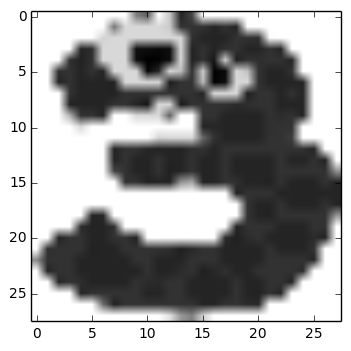

In [109]:
from matplotlib import pyplot as plt
% matplotlib inline
plt.imshow(resize_image,cmap='gray')
plt.show()

In [110]:
# test real data
def nn_predict(data):
  logit = sess.run(logits,feed_dict= {X:data.reshape(1,784)})
  return sess.run(tf.argmax(logit,1))
  
import warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")  # suppress warning caused by single sample test

  pred = nn_predict(resize_image)
  print ' predict = {0}'.format(pred[0])


 predict = 3


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:** It is quite exciting to use some captured images to test my model. Basically, I have 2 sources to get images. 
- shot by iphone 5s and airdrop to mac as jpg file. However, when I use opencv to imread and convert it to grayscale. These images are discontinuous, even difficult for human eye to recognize. I guess these jpg files are special coded, which causes problem when converting into arrays. 
- download from internet, some images have special effect, which may fool the prediction model. It turns out, the normal images can be easily recognized, the special effect images can't be. 

So the image quality still matters a lot. 

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**  No. It's still about the image quality. How the image is captured and the format it stores still play an important part.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** A workflow from image to final identification is:
1. use camera to capture a real world image
2. store this image in png or jpg format
3. use opencv.imread() to convert png file to 3d numpy array
4. convert to 2d numpy array (greyscale)
5. use opencv.resize() to resize it to a 28 * 28 array
6. normalize the values in the range of [-0.5,0.5]
7. use pre-train neural network model to predict the result

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a **localizer**. Train a **regression loss** to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

---
I am not sure the correct way to contruct a localizer. My thought process is:
1. the localizer has an input layer of a fix-size 28*28 nuerons, output layer is a binary classifier. 
2. use 28*28 single-digit images as well as 28*28 blank images to train the model
3. For an arbitrary size images, if either the width or the height is smaller than 28, mark this image as negative: no digit. So we assume the localizer works in a large enough image. Use the localizer as a  **local receptive field** of the convolutional layer, move it block by block to capture the possible digits.

My question is: this localizer is a fix size, which seems not satisfy the question asked. Do you have any suggestions?



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.


0

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.